In dit notebook gaan we financiële niews artikelen proberen te classificeren aan de hand van een word2vec model. Eerst gaan er pre-processing stappen plaats vinden om de data schoon te maken zodat dit gebruikt kan worden voor het trainen van het llm model. Dit llm model wordt dan gebruikt om features te maken zodat deze gebruikt kunnen worden door een classificatie model. Dit model probeert dan te voorspellen wat het sentiment is van een nieuws artikel en wordt vervolgens gebruikt om een advies te genereren (via een ander model/notebook die later samen gevoegd gebracht worden middels een API). Dit notebook is puur voor het trainen het/de model(len).

Om een begin te maken aan dit notebook is er gebruik gemaakt van een financial news dataset [1] op kaggle om dit model op te trainen. Ook is dit notebook gebasseerd op tutorials van kaggle [2][3] en zijn er aanpassing gemaakt zodat dit kan werken op ons probleem.

In [122]:
#Import libraries

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import kagglehub
import string
import re
from gensim.models import word2vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Als eerst wordt de besproken dataset van financieel nieuws ingeladen. Als extra bijkomstigheid laden we ook 2 woorden lijsten [4] in die al geclassificeerd zijn als positief of negatief (Alle woorden die hier niet tussen staan worden als neutraal beschouwd)

In [123]:
# Download latest version
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

print("Path to dataset files:", path)

postive_words_file = open("positive-words.txt", "r")
negative_words_file = open("negative-words.txt", "r")

postive_words = postive_words_file.readlines()
negative_words = negative_words_file.readlines()

postive_words = set(map(lambda w: w.replace("\n", ""), postive_words))
negative_words = set(map(lambda w: w.replace("\n", ""), negative_words))


Path to dataset files: C:\Users\nicne\.cache\kagglehub\datasets\ankurzing\sentiment-analysis-for-financial-news\versions\5


Voordat we verder gaat met de rest moeten we eerst even naar het gegeven pad gaan om de file "all-data.csv" te kopiëren naar het project. Het direct gebruik maken van het pad voor het lezen van de file geeft een permission denied error.

In [124]:
#read the data
df = pd.read_csv("all-data.csv", names=["sentiment", "text"],encoding="utf-8", encoding_errors="replace")
df

,sentiment,text
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ..."
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .
4842,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres ."
4843,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn ."
4844,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose t..."


Nu dat de data is ingelezen gaan we beginnen met data exploratie. 

In [125]:
# Mocht je een andere sentiment willen zien dan moet je de geactiveerde lijn commenten en de gewenste lijn uncommenten.

# Hoe zien de positieve sentimenten er uit
df[df["sentiment"] == "positive"]

# Hoe zien de neutrale sentimenten er uit
#df[df["sentiment"] == "neutral"]

# Hoe zien de negatieve sentimenten er uit
#df[df["sentiment"] == "negative"]


,sentiment,text
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ..."
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
6,positive,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ."
7,positive,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn ."
...,...,...
4775,positive,"The apartment block will be well-located , in easy reach of the city center and close to both a school and kindergarten ."
4780,positive,"The antibody , given at repeated doses of up to 8 mg-kg , was generally well tolerated , and the pharmacokinetic characteristics of BTT-1023 in psoriasis patients were consistent with those observ..."
4786,positive,"Danske Bank A-S DANSKE DC jumped 3.7 percent to 133.4 kroner , rebounding from yesterday s 3.5 percent slide ."
4787,positive,Our superior customer centricity and expertise in digital services set us apart from our competitors .


Nu gaan we kijken naar hoeveel woorden elke tekst heeft. Na inspectie kunnen we zien dat de meeste teksten veel woorden hebben. Hier zouden we potentiëel goede word embedding maken.

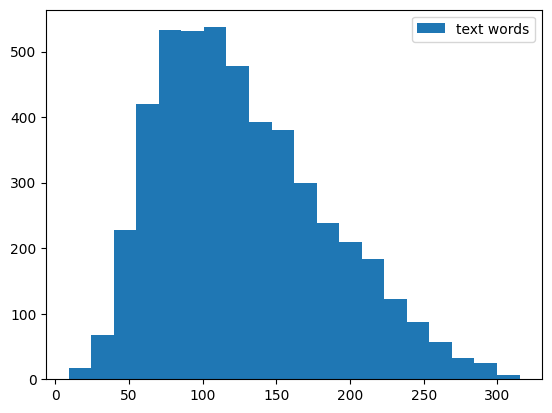

In [126]:
plt.hist(df.text.str.len(), bins=20, label='text words')
plt.legend()
plt.show()

Nu kunnen we gaan beginnen met de eerste pre-processing stappen. Om te beginnen wordt alles naar lower case gebracht en wordt interpunctie verwijderd. Later worden er stopwoorden verwijderd.

In [127]:
def lower_punctuation_no_numbers(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

df["clean_text_tokenized"] = df["text"].apply(lower_punctuation_no_numbers)


def remove_stop_words(text:str):
    stop_words = set(stopwords.words("english")) - set(["no"]) # omit the word "no" from stopwords, because it can contain negative sentiment
    
    tokenized_text = word_tokenize(text)

    filtered_text = [w for w in tokenized_text if not w in stop_words]
    return filtered_text

df["clean_text_tokenized"] = df["clean_text_tokenized"].apply(remove_stop_words)

# counts positive words in sentence
def add_positive_words(tokens):
    count = 0
    for token in tokens:
        if token in postive_words:
            count += 1
    return count

# counts negative words in sentence
def add_negative_words(tokens):
    count = 0
    for token in tokens:
        if token in negative_words:
            count += 1
    return count

# calculates average sentiment from text if value > 0 then positive, if value < 0 then negative, if value == 0 then neutral
def average_word_sentiment(tokens):
    if len(tokens) == 0:
        return 0
    pos = add_positive_words(tokens)
    neg = add_negative_words(tokens)
    avg = (pos-neg) / (len(tokens))
    return avg


df["postive_word_count"] = df["clean_text_tokenized"].apply(add_positive_words)
df["negative_word_count"] = df["clean_text_tokenized"].apply(add_negative_words)
df["avg_sentiment_of_words"] = df["clean_text_tokenized"].apply(average_word_sentiment)

# map the sentiments to a number
mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}


df["labels"] = df["sentiment"].map(mapping)
df
    

,sentiment,text,clean_text_tokenized,postive_word_count,negative_word_count,avg_sentiment_of_words,labels
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .","[according, gran, company, no, plans, move, production, russia, although, company, growing]",0,0,0.000000,1
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .","[technopolis, plans, develop, stages, area, no, less, square, meters, order, host, companies, working, computer, technologies, telecommunications, statement, said]",0,0,0.000000,1
2,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...,"[international, electronic, industry, company, elcoteq, laid, tens, employees, tallinn, facility, contrary, earlier, layoffs, company, contracted, ranks, office, workers, daily, postimees, reported]",0,0,0.000000,0
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...,"[new, production, plant, company, would, increase, capacity, meet, expected, increase, demand, would, improve, use, raw, materials, therefore, increase, production, profitability]",1,0,0.050000,2
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ...","[according, company, updated, strategy, years, basware, targets, longterm, net, sales, growth, range, operating, profit, margin, net, sales]",0,0,0.000000,2
...,...,...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,"[london, marketwatch, share, prices, ended, lower, london, monday, rebound, bank, stocks, failed, offset, broader, weakness, ftse]",0,2,-0.125000,0
4842,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres .","[rinkuskiai, beer, sales, fell, per, cent, million, litres, kauno, alus, beer, sales, jumped, per, cent, million, litres]",0,1,-0.058824,1
4843,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .","[operating, profit, fell, eur, mn, eur, mn, including, vessel, sales, gain, eur, mn]",1,1,0.000000,0
4844,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose t...","[net, sales, paper, segment, decreased, eur, mn, second, quarter, eur, mn, second, quarter, operating, profit, excluding, nonrecurring, items, rose, eur, mn, eur, mn]",0,0,0.000000,0


Nu dat de pre-processing stappen zijn voltooid kunnen we beginnen aan het trainen van het model.

In [128]:
# split data into train, test and validation
sentences = df["clean_text_tokenized"]

# Creating the model and setting values for the various parameters
num_features = 100  # Word vector dimensionality
min_word_count = 2 # Minimum word count to get included in model
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
print("Training model....")
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          vector_size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

model.init_sims(replace=True)
model.train(sentences, total_examples= len(df['clean_text_tokenized']), epochs=20)
df.shape

Training model....


(4846, 7)

Nu gaan we Word2Vec features maken voor het model

In [129]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec


In [130]:
wordvec_arrays = np.zeros((len(sentences), 100)) 
for i in range(len(sentences)):
    wordvec_arrays[i,:] = word_vector(sentences[i], 100)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(4846, 100)

Nu dat we de Word2Vec features hebben gemaakt gaan we voor nu een Random Forest Classifier gebruiken om sentiment te bepalen. (Later kunnen er meerdere modellen getest worden, dit is nu puur voor een proof of concept).

(4846, 107)


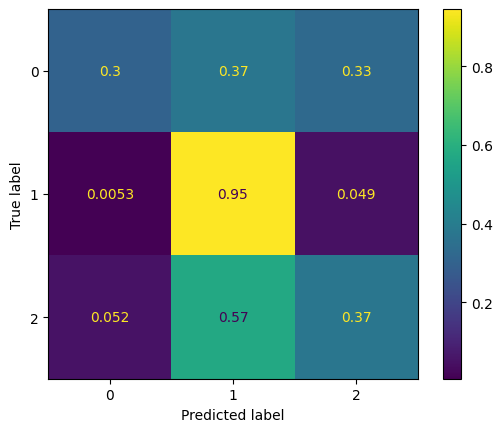

F1 score


0.5659692982277695

In [131]:
df = df.join(wordvec_df)
print(df.shape)
X = df.drop(["labels","sentiment","text","clean_text_tokenized"], axis=1)
X.columns = X.columns.astype(str)
y = df["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rand_forest = RandomForestClassifier(n_estimators=200)
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)

cm = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapping.values())
disp.plot()
plt.show()

print("F1 score")
sklearn.metrics.f1_score(y_test, y_pred, average="macro")

Bronnen:

[1] Sinha, A. (2020). Sentiment analysis for financial news [Dataset]. Kaggle. Retrieved from https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

[2] Varun, D. (2018). Sentiment analysis using Word2Vec. Kaggle. Retrieved from https://www.kaggle.com/code/varun08/sentiment-analysis-using-word2vec

[3] Nitin, G. (2019). Twitter sentiment analysis - word2vec, doc2vec. Kaggle. Retrieved from https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec

[4] Kanad, P. (2024). Sentiment analysis word lists dataset [Dataset]. Kaggle. Retrieved from https://www.kaggle.com/datasets/prajwalkanade/sentiment-analysis-word-lists-dataset?resource=download